## Introduction

The project creates time series predictions of Covid cases using data from John Hopkins University. The data contains confirmed deaths and confirmed cases of Covid-19 on a national basis. We visualize the number of deaths for each country on a map projection and later illustrate the total global death count and use the FB prophet model to do a 30-day future projection of the number of cases.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import re

In [2]:
df_conf_cases = pd.read_csv("data/CONVENIENT_global_confirmed_cases.csv")
df_deaths = pd.read_csv("data/CONVENIENT_global_deaths.csv")
continent = pd.read_csv("data/continents.csv")

### Data transformation

In [3]:
df_deaths = df_deaths.iloc[1:].reset_index(drop=True)
df_deaths = df_deaths.loc[:, df_deaths.sum(axis=0) != 0] # removing columns with all zeros
df_deaths['Country/Region'] = pd.to_datetime(df_deaths['Country/Region'], format='%m/%d/%y') #correct date format
df_deaths = df_deaths.rename(columns={"Country/Region": "Date"})

In [4]:
df_deaths.columns = df_deaths.columns.str.replace(r'\.\d+', '', regex=True)
df_deaths = df_deaths.set_index('Date')
df_deaths = df_deaths.apply(pd.to_numeric, errors='coerce')
df_deaths = df_deaths.groupby(df_deaths.columns, axis=1).sum()
df_deaths.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_world = pd.DataFrame(df_deaths.sum(axis=0)).reset_index()
df_world.columns = ['Country','Number deaths']
df_world.head()

,Country,Number deaths
0,Afghanistan,7896.0
1,Albania,3598.0
2,Algeria,6881.0
3,Andorra,165.0
4,Angola,1933.0


In [6]:
df_world['Country'] = df_world['Country'].replace('US', 'United States').replace('Taiwan*', 'Taiwan').replace('Brunei', 'Brunei Darussalam')
df_world['Code'] = df_world["Country"].map(continent.set_index('name')['alpha-3'])
df_world.tail()

,Country,Number deaths,Code
191,Vietnam,43186.0,VNM
192,West Bank and Gaza,5708.0,NaN
193,Yemen,2159.0,YEM
194,Zambia,4057.0,ZMB
195,Zimbabwe,5671.0,ZWE


### Data visualization

We visualize the total number of reported deaths related to Covid-19 per country using a map projector.

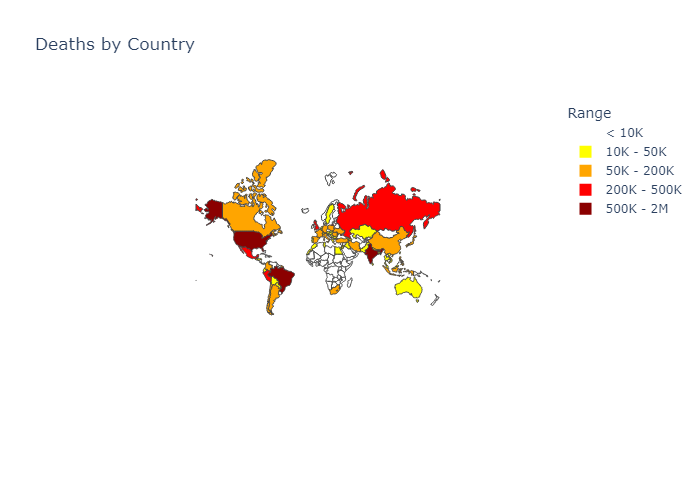

In [7]:
df_world["Range"] = pd.cut(df_world["Number deaths"], 
                        bins=[0, 10_000, 50_000, 200_000, 500_000, 2_000_000], 
                        labels=["< 10K", "10K - 50K", "50K - 200K", "200K - 500K", "500K - 2M"])

color_mapping = {
    "< 10K": "white",
    "10K - 50K": "yellow",
    "50K - 200K": "orange",
    "200K - 500K": "red",
    "500K - 2M": "darkred"
}
category_order = ["< 10K", "10K - 50K", "50K - 200K", "200K - 500K", "500K - 2M"]

# Step 3: Create the choropleth map using Plotly
fig = px.choropleth(df_world,
                    locations="Code",  # Assuming 'index' now holds the country names
                    color="Range",
                    category_orders={"Range": category_order},
                    projection="mercator",
                    hover_name="Country",  # This will display the country name
                    hover_data=["Number deaths"],  # This will display the number of deaths
                    color_discrete_map=color_mapping,
                    title="Deaths by Country")

# Step 4: Customize the layout and show the plot
fig.update_geos(fitbounds="locations", visible=False)  # Optional, to fit the map to the countries shown

fig.show("png")


## Time series prediction

We turn to daily global cases and construct a time series to see the development.

In [8]:
df_conf_cases = df_conf_cases.iloc[1:]
df_conf_cases['Country/Region'] = pd.to_datetime(df_conf_cases['Country/Region'], format='%m/%d/%y') #correct date format
df_conf_cases = df_conf_cases.rename(columns={"Country/Region": "Date"})
df_conf_cases = df_conf_cases.set_index('Date')
df_conf_cases = df_conf_cases.apply(pd.to_numeric, errors='coerce')
df_conf_cases['Total'] = df_conf_cases.sum(axis=1)
df_conf_cases['30 days moving average'] = df_conf_cases['Total'].rolling(30).mean().shift(-15)
df_conf_cases.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,Australia,...,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe,Total,30 days moving average
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0,NaN
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,493.0,NaN
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,683.0,NaN
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,809.0,NaN


Below we visualize the total number of daily global cases along with a 30-day moving average.

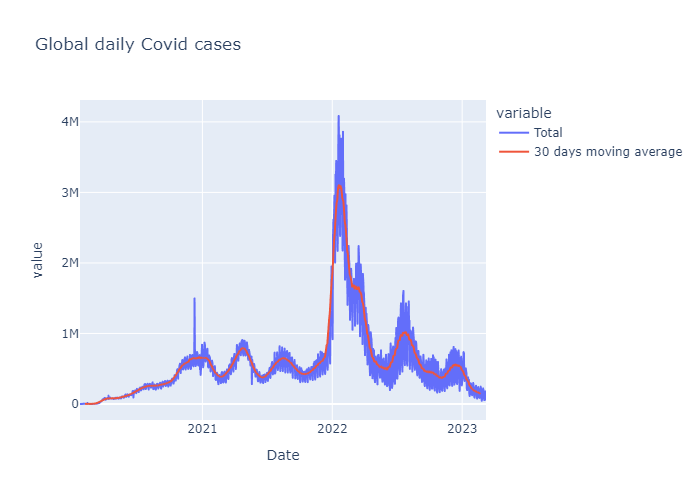

In [9]:
fig = px.line(df_conf_cases, x=df_conf_cases.index, y=['Total', '30 days moving average'], title = 'Global daily Covid cases')
fig.show("png")


Let's see if we can predict the last development in global Covid cases that occurred in 2023 with the FB Prophet model.

In [10]:
from prophet import Prophet
df_cases = pd.DataFrame(df_conf_cases.iloc[:, -2]).reset_index()
df_cases = df_cases.rename(columns={"Date": "ds", "Total": "y"}) 

# Ensure 'y' column is numeric
df_cases['y'] = pd.to_numeric(df_cases['y'], errors='coerce')

df_cases = df_cases.dropna(subset=['y'])

df_cases['ds'] = pd.to_datetime(df_cases['ds'])


We create a training dataset and a testing dataset for validation.

In [11]:
FORECAST_PERIOD = 30
df_train = df_cases.iloc[:-FORECAST_PERIOD]
df_test = df_cases.iloc[-FORECAST_PERIOD:]

In [12]:
model_prophet  = Prophet()
model_prophet.fit(df_train)

11:36:48 - cmdstanpy - INFO - Chain [1] start processing
11:36:48 - cmdstanpy - INFO - Chain [1] done processing


We predict the model on the test data.

In [13]:
forecast = model_prophet.predict(df_test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
25,2023-03-05,-307894.255585,-704833.298165,106437.489018
26,2023-03-06,-124381.123489,-505293.335559,269759.258032
27,2023-03-07,-55068.189162,-451398.325869,347233.756346
28,2023-03-08,-14956.332444,-432477.778669,351546.472100
29,2023-03-09,-17293.139717,-405740.261798,390796.944510


In [14]:
future = pd.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], df_test, on='ds')
future.tail()

,ds,yhat,yhat_lower,yhat_upper,y
25,2023-03-05,-307894.255585,-704833.298165,106437.489018,56126.0
26,2023-03-06,-124381.123489,-505293.335559,269759.258032,58040.0
27,2023-03-07,-55068.189162,-451398.325869,347233.756346,130437.0
28,2023-03-08,-14956.332444,-432477.778669,351546.472100,179446.0
29,2023-03-09,-17293.139717,-405740.261798,390796.944510,177325.0


Create a time series of actual observed (black data points), the forecast and uncertainty interval (blue) and the actual test data for validation (purple).

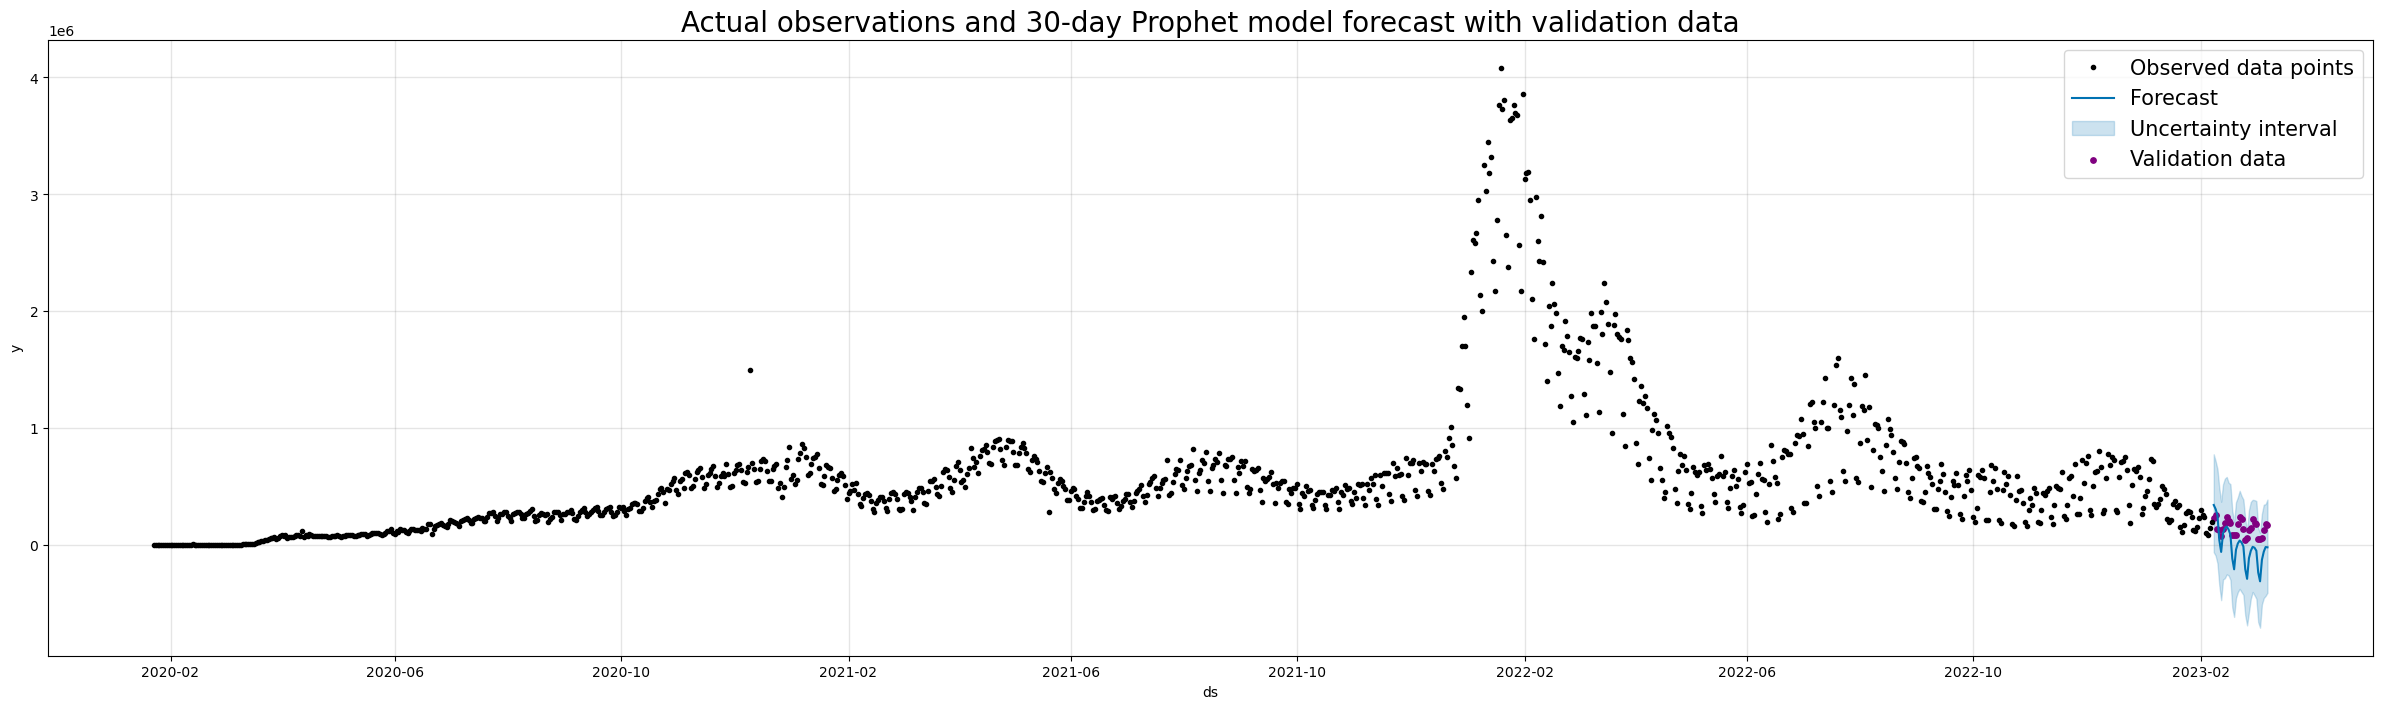

In [19]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(30,8))

model_prophet.plot(forecast, ax=ax1)

# Add future validation values
ax1.scatter(future['ds'], future['y'], color='purple', s=15, label='Validation data')

ax1.legend(fontsize=15)
ax1.set_title('Actual observations and 30-day Prophet model forecast with validation data', fontsize=20)
plt.show()

The model predicts a somewhat faster decline in Covid cases in the last 30 days compared to the development in actual validation data